In [3]:
from pytfa.io.json import load_json_model
from skimpy.io.yaml import  load_yaml_model
from skimpy.analysis.oracle.load_pytfa_solution import load_concentrations, load_fluxes
from skimpy.core.parameters import ParameterValues
from skimpy.utils.namespace import *
from skimpy.core.modifiers import *
from skimpy.io.yaml import load_yaml_model
from skimpy.core.reactor import Reactor
from skimpy.analysis.oracle.load_pytfa_solution import load_concentrations, load_fluxes
from skimpy.viz.plotting import timetrace_plot
from pytfa.io.json import load_json_model
from skimpy.io.yaml import load_yaml_model
from skimpy.analysis.oracle.load_pytfa_solution import load_concentrations
from skimpy.core.parameters import load_parameter_population
from skimpy.simulations.reactor import make_batch_reactor
from skimpy.core.solution import ODESolutionPopulation
from skimpy.utils.namespace import *
from skimpy.viz.escher import animate_fluxes, plot_fluxes
import copy
from skimpy.io.yaml import export_to_yaml
from skimpy.analysis.ode.utils import make_flux_fun

import pandas as pd
import numpy as np

import skimpy
import time
import matplotlib.pyplot as plt
import itertools
import matplotlib
import sys
sys.path.insert(1, 'functions/')


# benchmark functions
import simulation_functions as sf
import scenarios as sc
import visualizations as vis


#ML methods
from sklearn import svm
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import r2_score
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import  AdaBoostRegressor

from scipy.stats import linregress

In [4]:
# functions
def scenario_simulation(designs,kmodel,sol_wt,parameter_values,cart):
    """Simulate a scenario based on the design list
    Input: Vmax Design List, Cartesian Design List,kmodel
    
    #cart, the design list for the index of vmax 
    
    Output: 
    - Relative Flux Change w.r.t Wildtype
    - Relative Metabolite Change w.r.t Wildtype
    - Design list for training"""
    #the perturbation integration
    met_plots="glx_c" #this I should remove from the function, no longer used
    rel_list=[]
    rel_flux_list=[]
    vmax_list=[]
    for i in designs:
        pmodel=sf.perturb_kmodel(kmodel,i,parameter_values)
        sol=sf.ode_integration(pmodel,met_plots,plotting=False)
        #vmax dictionary
        perturbed_values = {p.symbol:p.value for p in pmodel.parameters.values()}
        vmax=sf.vmax_finder(perturbed_values)
        vmax_index=list(vmax.keys())
        vmax=list(vmax.values())
        vmax_list.append(vmax)

        if sol.ode_solution.message=='Successful function return.':

            rel_change=sf.relative_met_change(sol_wt,sol)
            rel_list.append(rel_change)

            pmodel_parameters = {p.symbol:p.value for p in kmodel.parameters.values()}
            pmodel_parameters = ParameterValues(parameter_values, pmodel)
            for j,concentrations in sol.concentrations.iterrows():  
                flux_mt=flux_fun(concentrations,parameters=pmodel_parameters)
            rel_flux=sf.relative_flux_change(flux_wt,flux_mt)
            rel_flux_list.append(rel_flux)
        else:
            my_list=np.zeros(49)
            my_flux_list=np.zeros(65)
            my_list[:]=np.NaN
            my_flux_list[:]=np.NaN
            rel_list.append(my_list)
            rel_flux_list.append(my_flux_list)
    

    # Change in metabolite
    rel_change=pd.DataFrame(np.array(rel_list))
    rel_change.columns=sol_wt.names
    rel_change.index=cart

    #Change in flux
    rel_flux_change=pd.DataFrame(np.array(rel_flux_list))
    rel_flux_change.index=cart
    rel_flux_change.columns=list(flux_wt.keys())

    vmax=pd.DataFrame(np.array(vmax_list))
    vmax.columns=vmax_index
    vmax.index=cart
    vmax['Enzyme_G']=rel_flux_change['Enzyme_G']
    
    training_set=pd.DataFrame(np.array(list(vmax.index)),columns=enz_names)
    training_set['Enzyme_G']=list(vmax['Enzyme_G'])
    return rel_change, rel_flux_change, vmax,training_set


def test_set1_Xy(cart,cart_scenario,enz_names,test_set_size):
    """testing on a set of unseen examples
    - cart: set of designs from the full combinatorial space
    - cart_scenario: trainingset
    - N: size of the test_set"""
    test_cart=[]
    test_set_design=[]
    for i in cart:
        for j in cart_scenario:
            if i!=j:
                test_cart.append(i)
    index_set=np.arange(0,len(test_cart),1)
    random_choice=np.random.choice(index_set,test_set_size,replace=False)
    
    test_cart=[test_cart[i] for i in random_choice]
    cart_ind=test_cart
    #make a designlist from test
    for i in test_cart:
        temp=dict(zip(enz_names,i))
        test_set_design.append(temp)
    #make it a dataframe for prediction
    test_cart=pd.DataFrame(test_cart,columns=enz_names)
    return test_cart,test_set_design,cart_ind

def ML_methods(training_set,test_set):
    "wrapper s.t. we can call it iteratively for each scenario"
    #train test split
    X=['vmax_forward_Enzyme_A','vmax_forward_Enzyme_B',"vmax_forward_Enzyme_C",
       "vmax_forward_Enzyme_D","vmax_forward_Enzyme_E","vmax_forward_Enzyme_F","vmax_forward_Enzyme_G"]
    train_x=training_set_sc1[X]
    train_y=training_set_sc1['Enzyme_G']
    test_x=test_set_simulation[X]
    test_y=test_set_simulation['Enzyme_G']
    
    #svr
    regr_svr = svm.SVR()
    regr_svr.fit(train_x, train_y)
    prediction_svr=regr_svr.predict(test_x)
    slope, intercept, r_value, p_value, std_err = linregress(test_y,prediction_svr)
    score_svr=r_value**2
    
    #score_svr=regr_svr.score(test_x,test_y)
    #print("Support Vector Regressor: "+str(regr_svr.score(test_x,test_y)))
    #sgd
    regr_sgd = make_pipeline(StandardScaler(),SGDRegressor(loss="squared_error",max_iter=1000, tol=1e-3))
    regr_sgd.fit(train_x, train_y)
    predict_sgd=regr_sgd.predict(test_x)
    slope, intercept, r_value, p_value, std_err = linregress(test_y,predict_sgd)
    score_sgd=r_value**2
    

    #print("Stochastic Gradient Descent Regressor: "+str(regr_sgd.score(test_x,test_y)))
    #rf
    regr_rf = RandomForestRegressor()
    regr_rf.fit(train_x, train_y)
    predict_rf=regr_rf.predict(test_x)
    slope, intercept, r_value, p_value, std_err = linregress(test_y,predict_rf)
    score_rf=r_value**2

    #print("Random Forest: "+str(regr_rf.score(test_x,test_y)))
    #Elastic Net
    regr_elasticnet=ElasticNet()
    regr_elasticnet.fit(train_x,train_y)
    predict_elasticnet=regr_elasticnet.predict(test_x)
    slope, intercept, r_value, p_value, std_err = linregress(test_y,predict_elasticnet)
    score_elasticnet=r_value**2
    
    #print("Elastic Net: "+str(regr_elasticnet.score(test_x,test_y)))
    #KNN
    regr_knn=KNeighborsRegressor(n_neighbors=5,weights="distance")
    regr_knn.fit(train_x,train_y)
    predict_knn=regr_knn.predict(test_x)
    slope, intercept, r_value, p_value, std_err = linregress(test_y,predict_knn)
    score_knn=r_value**2
    
    #print("k Nearest Neighbors: "+str(regr_knn.score(test_x,test_y)))
    #GPR
    regr_GPR=GaussianProcessRegressor()
    regr_GPR.fit(train_x,train_y)
    predict_GPR=regr_GPR.predict(test_x)
    slope, intercept, r_value, p_value, std_err = linregress(test_y,predict_GPR)
    score_GPR=r_value**2
    
    #print("Gaussian Process Regressor: "+str(regr_GPR.score(test_x,test_y))) 
    #this is probably an algorithm that needs to be finetuned more
    #Gradient boosting Regressor
    regr_GradBoostReg=GradientBoostingRegressor()
    regr_GradBoostReg.fit(train_x,train_y)
    predict_GradBoostReg=regr_GradBoostReg.predict(test_x)
    slope, intercept, r_value, p_value, std_err = linregress(test_y,predict_GradBoostReg)
    score_GradBoost=r_value**2
    
    #print("Gradient Boosting Regressor: "+str(regr_GradBoostReg.score(test_x,test_y))) 
    # Neural Network
    regr_NN=MLPRegressor(max_iter=8000,activation="relu", learning_rate="adaptive")
    regr_NN.fit(train_x,train_y)
    predict_NN=regr_NN.predict(test_x)
    slope, intercept, r_value, p_value, std_err = linregress(test_y,predict_NN)
    score_NN=r_value**2
    
    #print("Neural Network: "+str(regr_NN.score(test_x,test_y))) 
    algorithms=["SVR","SGD","RF","EN","kNN","GPR","GBR","NN"]
    scores=[score_svr,score_sgd,score_rf,score_elasticnet,score_knn,score_GPR,score_GradBoost,score_NN]
    scores=dict(zip(algorithms,scores))
    return scores 



In [5]:
N_designs=3
N_test_set=3

filenames={
    "kmodel":"models/shiki_pathway_testmodel.yml",
    "tmodel":"models/shiki_pathway_testmodel_thermodynamic.json",
    "ref_solution":"data/sample06092022.csv",
    "batch_file":"models/single_species.yaml",
    "batch_kmodel":"models/kin_varma.yml"}

filenames={
    "kmodel":"models/shiki_pathway_testmodel.yml",
    "tmodel":"models/shiki_pathway_testmodel_thermodynamic.json",
    "ref_solution":"data/sample06092022.csv",
    "batch_file":"models/single_species.yaml",
    "batch_kmodel":"models/kin_varma.yml"}

#load kinetic model and get parameter values
kmodel,ref_concentrations,tmodel=sf.setup_ode_system(filenames['kmodel'],filenames['tmodel'],filenames['ref_solution'])
parameter_values = {p.symbol:p.value for p in kmodel.parameters.values()}
parameter_values = ParameterValues(parameter_values, kmodel)

#function in the skimpy package for retrieving the fluxes
flux_fun = make_flux_fun(kmodel, QSSA)


met_plots="glx_c"
#kinetic model wildtype ode integration
sol_wt=sf.ode_integration(kmodel,met_plots,plotting=False)
for i,concentrations in sol_wt.concentrations.iterrows():
            flux_wt=flux_fun(concentrations,parameters=parameter_values)


#enzymes to perturb ,'vmax_forward_PFK'
enz_names=["vmax_forward_Enzyme_A","vmax_forward_Enzyme_B","vmax_forward_Enzyme_C","vmax_forward_Enzyme_D",
           "vmax_forward_Enzyme_E","vmax_forward_Enzyme_F","vmax_forward_Enzyme_G"] #'vmax_forward_LDH_D',
perturb_range=[0.25,0.5,1,1.5,2,4]


#perturb_range=[1,1.1,1.2]
#for the kinetic model
designs,cart=sf.generate_perturbation_scheme(enz_names,perturb_range) 
rel_list=[]
rel_flux_list=[]
vmax_list=[]


scores_scenario1={}


sc1_designs,sc1_cart=sc.scenario1(perturb_range,N_designs,enz_names)
train_met_sc1,train_flux_sc1,train_vmax_sc1,training_set_sc1=scenario_simulation(sc1_designs,kmodel,
                                                                                  sol_wt,parameter_values,sc1_cart)


test_x,test_set_designs,cart_test=test_set1_Xy(cart,sc1_cart,enz_names,N_test_set)


#simulate the test set#BUUUGGGGGGG
test_met,test_flux,test_vmax,test_set_simulation=scenario_simulation(test_set_designs,kmodel,sol_wt,parameter_values,cart_test)


X=['vmax_forward_Enzyme_A','vmax_forward_Enzyme_B',"vmax_forward_Enzyme_C",
       "vmax_forward_Enzyme_D","vmax_forward_Enzyme_E","vmax_forward_Enzyme_F","vmax_forward_Enzyme_G"]
train_x=training_set_sc1[X]
train_y=training_set_sc1['Enzyme_G']
test_x=test_set_simulation[X]
test_y=test_set_simulation['Enzyme_G']


regr_GradBoostReg=GradientBoostingRegressor()
regr_GradBoostReg.fit(train_x,train_y)
predict_GradBoostReg=regr_GradBoostReg.predict(test_x)
slope, intercept, r_value, p_value, std_err = linregress(test_y,predict_GradBoostReg)
score_GradBoost=r_value**2

2022-10-28 13:55:33,314 - Unnamed - WARNING - Non integer stoichiometries found ['LMPD_biomass_c_17_462'] change to integer for linear dependencies
2022-10-28 13:55:33,598 - thermomodel_redGEMv1_MergedLMPDsAndBiomass - continuous - INFO - # Model initialized with units kcal/mol and temperature 298.15 K
2022-10-28 13:55:33,951 - Unnamed - WARNING - Non integer stoichiometries found ['LMPD_biomass_c_17_462'] change to integer for linear dependencies


In [8]:

#vis.metabolic_engineering_vis(sc1_cart,train_y)
inds=list(train_y.argsort()[::-1])
x=np.array(sc1_cart)[inds]
y=np.sort(train_y)[::-1]
#fig1,fig2,axs=vis.metabolic_engineering_vis(x,y,0.3)
print(x)
print(y)

[[1.5  2.   1.5  0.25 2.   0.25 1.  ]
 [4.   0.25 2.   1.   2.   0.25 4.  ]
 [2.   2.   0.5  0.5  0.25 4.   4.  ]]
[1.42428141 0.1886833  0.17761072]


In [10]:
#fig1.savefig("../../Results/Benchmark paper/example_fluxes.svg",bbox_inches='tight')
#fig2.savefig("../../Results/Benchmark paper/example_train_space.svg",bbox_inches='tight')

In [13]:
import xgboost as xgb
regr_xgb=xgb.XGBRegressor()
regr_xgb.fit(train_x,train_y)

predicted_xgb=regr_xgb.predict(test_x)
slope, intercept, r_value, p_value, std_err = linregress(test_y,predicted_xgb)
xgb_score=r_value**2
xgb_score

0.7736813180240416

In [14]:
score_GradBoost

0.8072258645238727

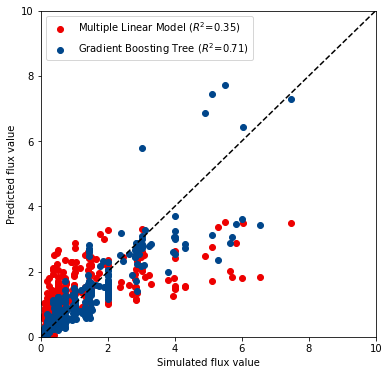

In [15]:

from scipy.stats import zscore
from sklearn.linear_model import LinearRegression
from sklearn import tree
from sklearn.neural_network import MLPRegressor

clf = tree.DecisionTreeRegressor()
clf = clf.fit(train_x, train_y)
pred_clf=clf.predict(test_x)

mlr=LinearRegression(fit_intercept=True)
mlr.fit(train_x,train_y)
pred_mlr=mlr.predict(test_x)
slope, intercept, r_value, p_value, std_err = linregress(test_y,pred_mlr)
score_mlr=r_value**2



fig, axs = plt.subplots(figsize=(6,6))
plt.scatter(test_y,pred_mlr,c="#ED0000FF",label="Multiple Linear Model ($R^2$=0.35)")
plt.scatter(test_y,predict_GradBoostReg,c="#00468BFF",label="Gradient Boosting Tree ($R^2$=0.71)")

#plt.scatter(test_y,predicted_xgb,label="XGboost")
#plt.scatter(test_y,pred_clf,label="Neural Network")
plt.xlabel("Simulated flux value")
plt.ylabel("Predicted flux value")
plt.axline((0, 0), slope=1,color="black",linestyle="--")
plt.ylim(0,10)
plt.xlim(0,10)

plt.legend()
#plt.legend(bbox_to_anchor=(1,1))
#plt.savefig("../../Results/Benchmark paper/example_predsimN400.svg",bbox_inches="tight")

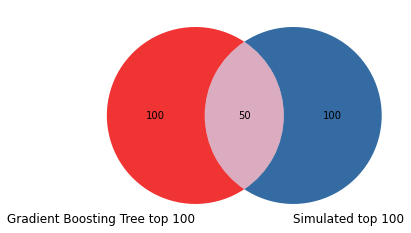

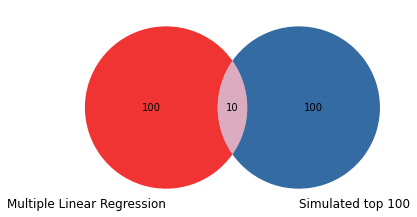

In [20]:
# library
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# Use the venn2 function
v=venn2(subsets = (100, 100, 50), set_labels = ('Gradient Boosting Tree top 100', 'Simulated top 100'),
      set_colors=["#ED0000FF","#00468BFF"],normalize_to=1)
v.get_patch_by_id('10').set_alpha(0.8)
v.get_patch_by_id('01').set_alpha(0.8)
matplotlib.pyplot.savefig('../../Results/Benchmark paper/venn2_NonLinear.svg',bbox_inches="tight")
plt.show()
#plt.savefig("../../Results/Benchmark paper/venn_grad.svg",bbox_inches="tight")

# Use the venn2 function
v=venn2(subsets = (100, 100, 10), set_labels = ('Multiple Linear Regression', 'Simulated top 100'),
      set_colors=["#ED0000FF","#00468BFF"],normalize_to=1)
v.get_patch_by_id('10').set_alpha(0.8)
v.get_patch_by_id('01').set_alpha(0.8)
matplotlib.pyplot.savefig('../../Results/Benchmark paper/venn2_LinearModel.svg',bbox_inches="tight")
plt.show()
#plt.savefig("../../Results/Benchmark paper/venn_mlr.svg",bbox_inches="tight")


In [40]:
regr_xgb.get_params

from skopt import BayesSearchCV

# log-uniform: understand as search over p = exp(x) by varying x
opt = BayesSearchCV(
    GradientBoostingRegressor(),
    {
        "min_samples_split":(2,3,4,5),
        "min_samples_leaf":(1,2,3),
        "max_depth":(2,3,4,5),
        "max_features":(1,2,3,4,5,6,7),
        
    },
    n_iter=10,
    cv=12)
opt.fit(train_x, train_y)
print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(test_x, test_y))
slope, intercept, r_value, p_value, std_err = linregress(opt.predict(test_x),test_y)

print("test score: %s" % r_value**2)


val. score: 0.7356161509913036
test score: 0.7666170256774564
test score: 0.7680383362441262


In [39]:
opt.best_estimator_

GradientBoostingRegressor(max_depth=4, max_features=6, min_samples_leaf=2,
                          min_samples_split=4)

# Bayesian optimization of hyperparameters

In [45]:
from skopt import BayesSearchCV

# log-uniform: understand as search over p = exp(x) by varying x
opt = BayesSearchCV(
    MLPRegressor(),
    {
        "activation":("relu","logistic"),
        "alpha":(1e-6,1e-5,1e-4,1e-3,1e-2,1e-1),
        "hidden_layer_sizes": (1,2,3,4,5),
        "max_iter":(200,500,1000,2000,5000,10000),
        #'learning_rate': (0.01,0.2,0.4,0.6),
        #'min_samples_split': (2,3,4)
    },
    n_iter=10,
    cv=5)

opt.fit(train_x, train_y)
print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(test_x, test_y))



/home/plent/anaconda3/envs/skimpy-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/plent/anaconda3/envs/skimpy-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/plent/anaconda3/envs/skimpy-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/plent/anaconda3/envs/skimpy-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged ye

/home/plent/anaconda3/envs/skimpy-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


val. score: 0.47014719048198145
test score: 0.5268294122630812


/home/plent/anaconda3/envs/skimpy-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [47]:
slope, intercept, r_value, p_value, std_err = linregress(opt.predict(test_x),test_y)

print("test score: %s" % r_value**2)


test score: 0.5315273209979258


In [19]:
regr_GradBoostReg.get_params().cr

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [4]:
from skopt import BayesSearchCV
from sklearn.datasets import load_digits
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

# log-uniform: understand as search over p = exp(x) by varying x
opt = BayesSearchCV(
    SVC(),
    {
        'C': (1e-6, 1e+6, 'log-uniform'),
        'gamma': (1e-6, 1e+1, 'log-uniform'),
        'degree': (1, 8),  # integer valued parameter
        'kernel': ['linear', 'poly', 'rbf'],  # categorical parameter
    },
    n_iter=32,
    cv=3
)

opt.fit(X_train, y_train)

print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))

GradientBoostingRegressor()

In [4]:
#print("Gradient Boosting Regressor: "+str(regr_GradBoostReg.score(test_x,test_y))) 
# Neural Network
regr_NN=MLPRegressor(max_iter=8000,activation="relu", learning_rate="adaptive")
regr_NN.fit(train_x,train_y)
predict_NN=regr_NN.predict(test_x)
slope, intercept, r_value, p_value, std_err = linregress(test_y,predict_NN)
score_NN=r_value**2

regr_rf = RandomForestRegressor()
regr_rf.fit(train_x, train_y)
predict_rf=regr_rf.predict(test_x)
slope, intercept, r_value, p_value, std_err = linregress(test_y,predict_rf)
score_rf=r_value**2


In [37]:
max_depth = list()
for tree in regr_rf.estimators_:
    max_depth.append(tree.tree_.max_depth)

In [131]:
seepath=np.array([4,1.5,3,3,1,3,3]).reshape(1,-1)

print(np.shape(seepath))
node_indicator=regr_rf.estimators_[2].decision_path(seepath)
leaf_id = regr_rf.estimators_[2].apply(seepath)
feature = regr_rf.estimators_[2].tree_.feature
threshold = regr_rf.estimators_[2].tree_.threshold
sample_id = 0

# obtain ids of the nodes `sample_id` goes through, i.e., row `sample_id`
node_index = node_indicator.indices[
    node_indicator.indptr[sample_id] : node_indicator.indptr[sample_id + 1]]

print("Rules used to predict sample {id}:\n".format(id=sample_id))
for node_id in node_index:
    # continue to the next node if it is a leaf node
    if leaf_id[sample_id] == node_id:
        continue
        
            # check if value of the split feature for sample 0 is below threshold
    if seepath[sample_id, feature[node_id]] <= threshold[node_id]:
        threshold_sign = "<="
    else:
        threshold_sign = ">"
    print(
        "decision node {node} : (X_test[{sample}, {feature}] = {value}) "
        "{inequality} {threshold})".format(
            node=node_id,
            sample=sample_id,
            feature=feature[node_id],
            value=seepath[sample_id, feature[node_id]],
            inequality=threshold_sign,
            threshold=threshold[node_id],))
    
regr_rf.estimators_[2].predict(seepath)

(1, 7)
Rules used to predict sample 0:

decision node 0 : (X_test[0, 6] = 3.0) > 0.75)
decision node 148 : (X_test[0, 0] = 4.0) > 0.75)
decision node 176 : (X_test[0, 6] = 3.0) > 1.25)
decision node 208 : (X_test[0, 6] = 3.0) <= 3.0)
decision node 209 : (X_test[0, 2] = 3.0) > 0.75)
decision node 239 : (X_test[0, 3] = 3.0) > 1.75)
decision node 273 : (X_test[0, 0] = 4.0) > 1.75)
decision node 277 : (X_test[0, 5] = 3.0) > 1.125)
decision node 279 : (X_test[0, 1] = 1.5) <= 2.75)
decision node 280 : (X_test[0, 2] = 3.0) > 1.75)


array([1.32975721])

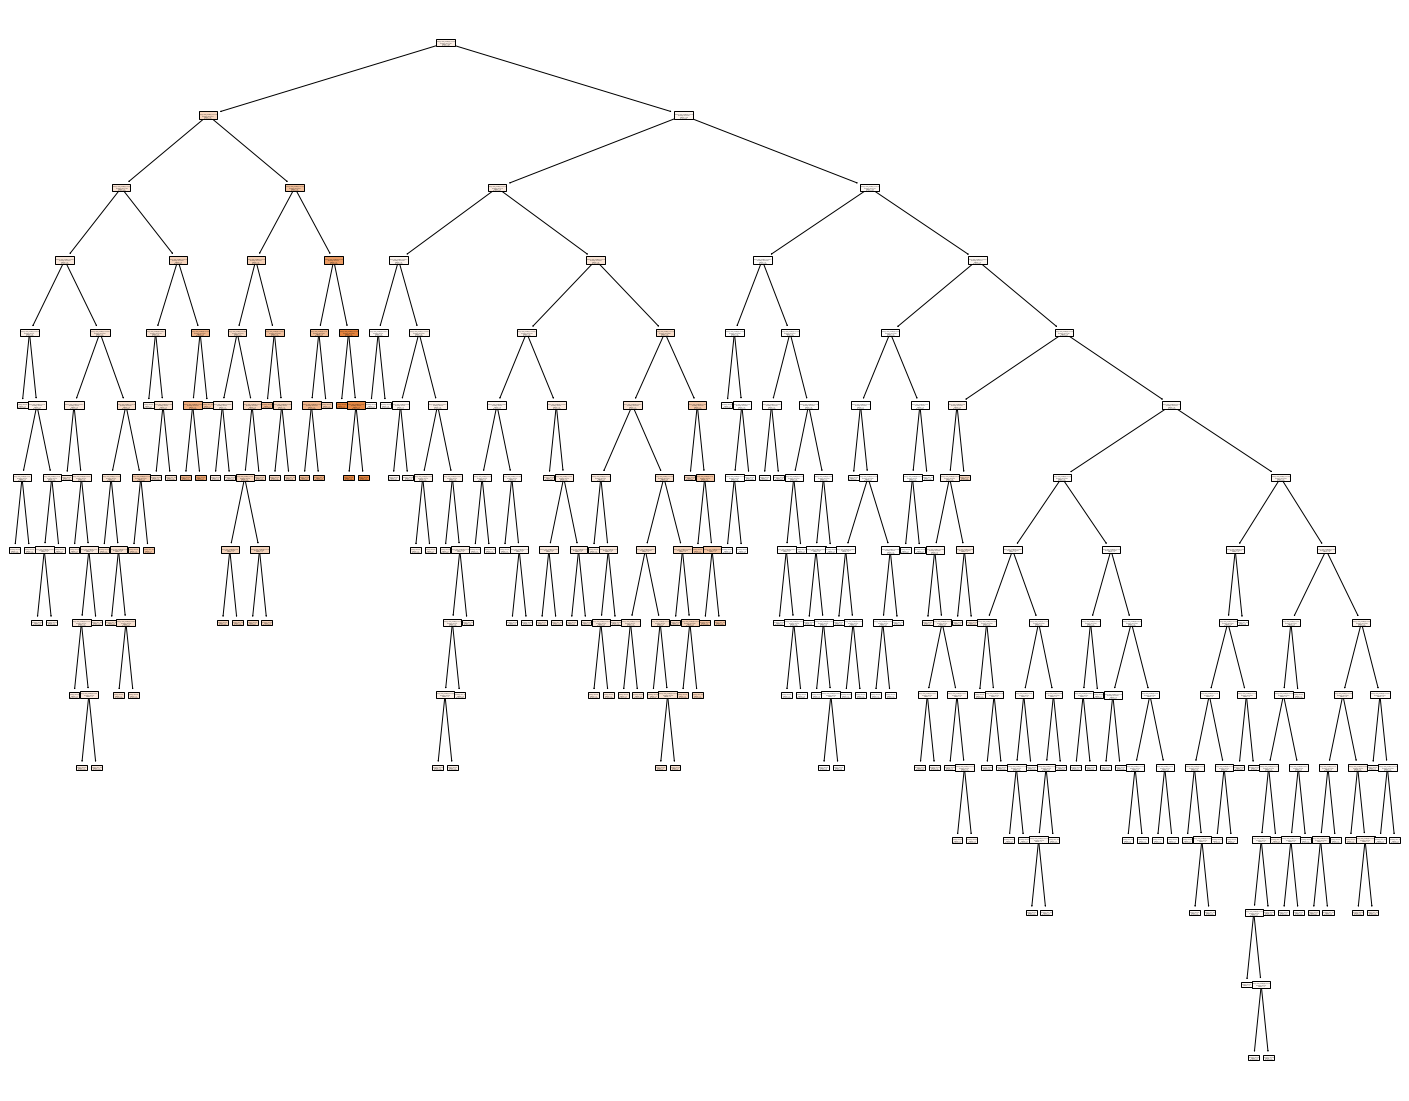

In [41]:
from sklearn import tree
estimator = regr_rf.estimators_[99]

text_representation = tree.export_text(estimator)
#print(text_representation)

plt.figure(figsize=(25,20))
tree.plot_tree(estimator, feature_names=enz_names, filled=True)
plt.savefig('tree.svg',format='svg',bbox_inches = "tight")

[0.5 1.5 2.5 3.5 4.5 5.5 6.5]


/tmp/ipykernel_8674/3445313895.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(enz_names)


[Text(-1.0, 0, 'vmax_forward_Enzyme_A'),
 Text(0.0, 0, 'vmax_forward_Enzyme_B'),
 Text(1.0, 0, 'vmax_forward_Enzyme_C'),
 Text(2.0, 0, 'vmax_forward_Enzyme_D'),
 Text(3.0, 0, 'vmax_forward_Enzyme_E'),
 Text(4.0, 0, 'vmax_forward_Enzyme_F'),
 Text(5.0, 0, 'vmax_forward_Enzyme_G'),
 Text(6.0, 0, ''),
 Text(7.0, 0, ''),
 Text(8.0, 0, '')]

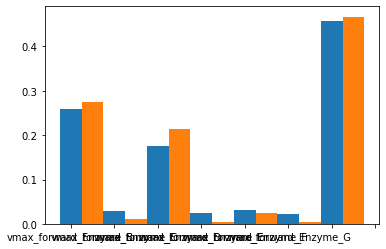

In [63]:
x=np.array([0,1,2,3,4,5,6])
print(x+0.5)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.bar(x,regr_rf.feature_importances_,width=0.5)
plt.bar(x+0.5,regr_GradBoostReg.feature_importances_,width=0.5)
ax.set_xticklabels(enz_names)

/home/plent/anaconda3/envs/skimpy-env/lib/python3.8/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/plent/anaconda3/envs/skimpy-env/lib/python3.8/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/plent/anaconda3/envs/skimpy-env/lib/python3.8/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


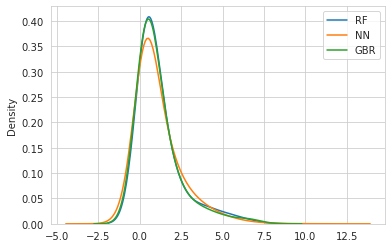

In [169]:
f, ax = plt.subplots(1, 1)


y=regr_rf.predict(pd.DataFrame(designs))
import functions.simulation_functions as sf
import seaborn as sns
sns.set_style('whitegrid')
sns.kdeplot(np.array(y),label="RF", bw=0.5)

y=regr_NN.predict(pd.DataFrame(designs))
import functions.simulation_functions as sf
import seaborn as sns
sns.set_style('whitegrid')
sns.kdeplot(np.array(y),label="NN", bw=0.5)

y=regr_GradBoostReg.predict(pd.DataFrame(designs))
import functions.simulation_functions as sf
import seaborn as sns
sns.set_style('whitegrid')
sns.kdeplot(np.array(y),label="GBR", bw=0.5)

ax.legend()

In [172]:
np.argmin(y)
designs[240629]

{'vmax_forward_Enzyme_A': 4.0,
 'vmax_forward_Enzyme_B': 0.25,
 'vmax_forward_Enzyme_C': 4.0,
 'vmax_forward_Enzyme_D': 2.0,
 'vmax_forward_Enzyme_E': 0.25,
 'vmax_forward_Enzyme_F': 0.25,
 'vmax_forward_Enzyme_G': 4.0}

In [13]:
from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = enz_names,
                class_names = "Enzyme_G",
                rounded = True, proportion = False, 
                precision = 2, filled = True)

TypeError: [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                       random_state=RandomState(MT19937) at 0x7F939C173540)] is not an estimator instance.

In [81]:
combinatorial_designspace=pd.DataFrame(designs)
predicted=regr_rf.predict(combinatorial_designspace)
np.argmax(predicted)
np.argsort
top_10_predicted=np.argsort(predicted)[::-1][0:50]
top_10_values=np.sort(predicted)[::-1][0:50]
best_cart=[cart[i] for i in top_10_predicted]
best_designs=[designs[i] for i in top_10_predicted]

In [82]:
np.max(top_10_values-train_flux_sc1['Enzyme_G'])

-0.44567500718226505

In [83]:
train_met_sc1,train_flux_sc1,train_vmax_sc1,training_set_sc1=scenario_simulation(best_designs,kmodel,
                                                                                  sol_wt,parameter_values,best_cart)

In [84]:

slope, intercept, r_value, p_value, std_err = linregress(top_10_values,train_flux_sc1['Enzyme_G'])
score_GradBoost=r_value**2
score_GradBoost

0.21684054933348015

2022-10-07 15:56:59,860 - Unnamed - WARNING - Non integer stoichiometries found ['LMPD_biomass_c_17_462'] change to integer for linear dependencies
2022-10-07 15:57:00,139 - thermomodel_redGEMv1_MergedLMPDsAndBiomass - continuous - INFO - # Model initialized with units kcal/mol and temperature 298.15 K
2022-10-07 15:57:00,460 - Unnamed - WARNING - Non integer stoichiometries found ['LMPD_biomass_c_17_462'] change to integer for linear dependencies


run0
run1


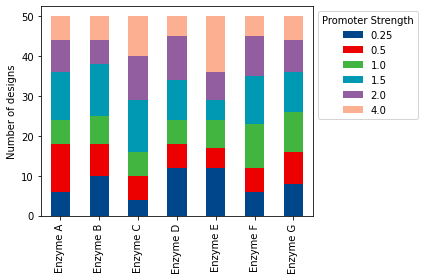

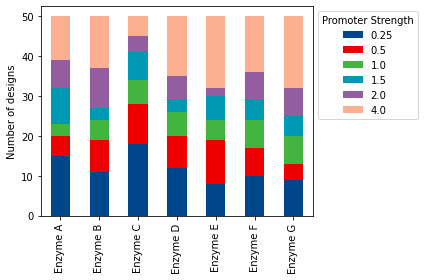

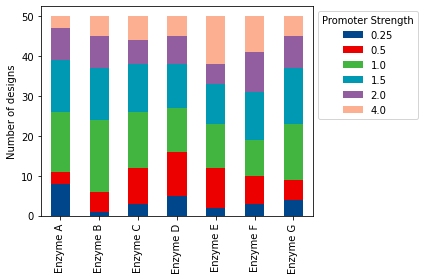

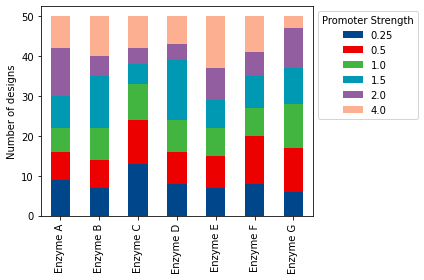

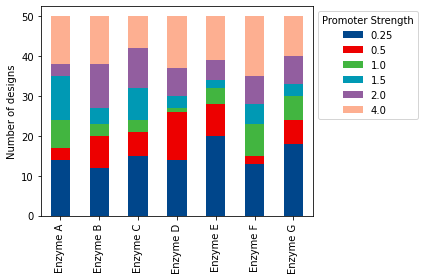

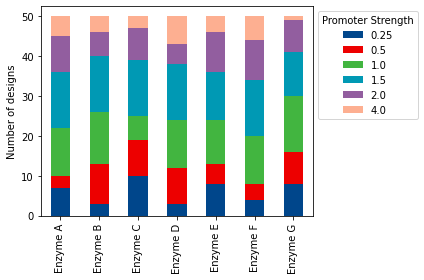

In [5]:
N_designs=50
N_test_set=10
N_iterations=2


filenames={
    "kmodel":"models/shiki_pathway_testmodel.yml",
    "tmodel":"models/shiki_pathway_testmodel_thermodynamic.json",
    "ref_solution":"data/sample06092022.csv",
    "batch_file":"models/single_species.yaml",
    "batch_kmodel":"models/kin_varma.yml"}

#load kinetic model and get parameter values
kmodel,ref_concentrations,tmodel=sf.setup_ode_system(filenames['kmodel'],filenames['tmodel'],filenames['ref_solution'])
parameter_values = {p.symbol:p.value for p in kmodel.parameters.values()}
parameter_values = ParameterValues(parameter_values, kmodel)

#function in the skimpy package for retrieving the fluxes
flux_fun = make_flux_fun(kmodel, QSSA)


met_plots="glx_c"
#kinetic model wildtype ode integration
sol_wt=sf.ode_integration(kmodel,met_plots,plotting=False)
for i,concentrations in sol_wt.concentrations.iterrows():
            flux_wt=flux_fun(concentrations,parameters=parameter_values)

#enzymes to perturb ,'vmax_forward_PFK'
enz_names=["vmax_forward_Enzyme_A","vmax_forward_Enzyme_B","vmax_forward_Enzyme_C","vmax_forward_Enzyme_D",
           "vmax_forward_Enzyme_E","vmax_forward_Enzyme_F","vmax_forward_Enzyme_G"] #'vmax_forward_LDH_D',
perturb_range=[0.25,0.5,1,1.5,2,4]


#perturb_range=[1,1.1,1.2]
#for the kinetic model
designs,cart=sf.generate_perturbation_scheme(enz_names,perturb_range) 
rel_list=[]
rel_flux_list=[]
vmax_list=[]


## From here we need to do repeats due to probabilistic nature of promoter choice
scores_scenario1={}
scores_scenario2={}
scores_scenario3={}
############
#Scenarios
for i in range(N_iterations):
    run_name="run"+str(i)
    print(run_name)
    ###############
    sc1_designs,sc1_cart=sc.scenario1(perturb_range,N_designs,enz_names)


    #plot_sc1.savefig("results/plots/svg/plot_sc1"+run_name+".svg")
    #plot_sc2.savefig("results/plots/svg/plot_sc2"+run_name+".svg")
    #plot_sc3.savefig("results/plots/svg/plot_sc3"+run_name+".svg")

    #plot_sc1.savefig("results/plots/png/plot_sc1"+run_name+".png")
    #plot_sc2.savefig("results/plots/png/plot_sc2"+run_name+".png")
    #plot_sc3.savefig("results/plots/png/plot_sc3"+run_name+".png")
    ##


    #simulate the different scenarios: training set
    train_met_sc1,train_flux_sc1,train_vmax_sc1,training_set_sc1=scenario_simulation(sc1_designs,kmodel,sol_wt,parameter_values,sc1_cart)
    #rel_change,rel_flux_change,vmax,full_set=scenario_simulation(designs,kmodel,sol_wt,parameter_values,cart)

    ######3
    #####
    #predict some instances as shown here
    test_x,test_set_designs,cart_test=test_set1_Xy(cart,sc1_cart,enz_names,N_test_set)

    #simulate the test set#BUUUGGGGGGG
    test_met,test_flux,test_vmax,test_set_simulation=scenario_simulation(test_set_designs,kmodel,sol_wt,parameter_values,cart_test)

    train_x=training_set_sc1[X]
    train_y=training_set_sc1['Enzyme_G']
    test_x=test_set_simulation[X]
    test_y=test_set_simulation['Enzyme_G']
    
    #append to dictionaries
    scores_scenario1[run_name]=scores_sc1

    regr_GradBoostReg=GradientBoostingRegressor()
    regr_GradBoostReg.fit(training_set_sc1,test_set_simulation)
    predict_GradBoostReg=regr_GradBoostReg.predict(test_x)
    slope, intercept, r_value, p_value, std_err = linregress(test_y,predict_GradBoostReg)
    score_GradBoost=r_value**2
#pd.DataFrame(scores_scenario1).T.to_csv("results/no_noise_sc1.csv")
#pd.DataFrame(scores_scenario2).T.to_csv("results/no_noise_sc2.csv")
#pd.DataFrame(scores_scenario3).T.to_csv("results/no_noise_sc3.csv")




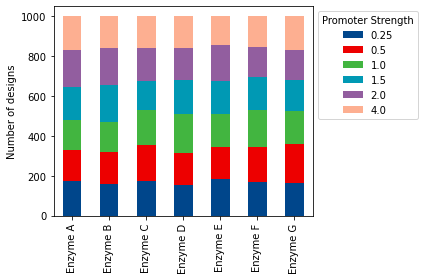

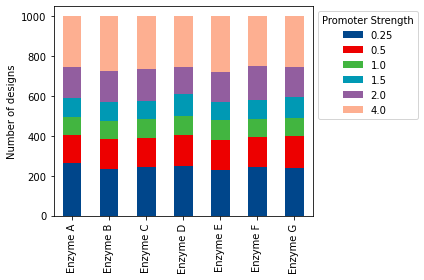

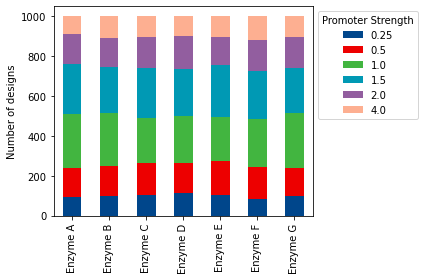

In [14]:
N_designs=1000

N_iterations=3

#enzymes to perturb ,'vmax_forward_PFK'
enz_names=["vmax_forward_Enzyme_A","vmax_forward_Enzyme_B","vmax_forward_Enzyme_C","vmax_forward_Enzyme_D",
           "vmax_forward_Enzyme_E","vmax_forward_Enzyme_F","vmax_forward_Enzyme_G"] #'vmax_forward_LDH_D',
perturb_range=[0.25,0.5,1,1.5,2,4]



#perturb_range=[1,1.1,1.2]
#for the kinetic model
designs,cart=sf.generate_perturbation_scheme(enz_names,perturb_range) 



sc1_designs,sc1_cart=sc.scenario1(perturb_range,N_designs,enz_names)
sc2_designs,sc2_cart=sc.scenario2(perturb_range,N_designs,enz_names)
sc3_designs,sc3_cart=sc.scenario3(perturb_range,N_designs,enz_names)
plot_sc1=sc.plot_promoter_distribution(enz_names,sc1_cart)
plot_sc2=sc.plot_promoter_distribution(enz_names,sc2_cart)
plot_sc3=sc.plot_promoter_distribution(enz_names,sc3_cart)
plot_sc1=plot_sc1.get_figure()
plot_sc2=plot_sc2.get_figure()
plot_sc3=plot_sc3.get_figure()
plot_sc1.tight_layout()
plot_sc2.tight_layout()
plot_sc3.tight_layout()

plot_sc1.savefig("results/plots/svg/plot_sc1"+run_name+".svg")
plot_sc2.savefig("results/plots/svg/plot_sc2"+run_name+".svg")
plot_sc3.savefig("results/plots/svg/plot_sc3"+run_name+".svg")

plot_sc1.savefig("results/plots/png/plot_sc1"+run_name+".png")
plot_sc2.savefig("results/plots/png/plot_sc2"+run_name+".png")
plot_sc3.savefig("results/plots/png/plot_sc3"+run_name+".png")

In [6]:
from skopt import BayesSearchCV
from sklearn.datasets import load_digits
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split

X, y = load_digits(n_class=10, return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, test_size=.25, random_state=0)

# log-uniform: understand as search over p = exp(x) by varying x
opt = BayesSearchCV(
    SVC(),
    {
        'C': (1e-6, 1e+6, 'log-uniform'),
        'gamma': (1e-6, 1e+1, 'log-uniform'),
        'degree': (1, 8),  # integer valued parameter
        'kernel': ['linear', 'poly', 'rbf'],  # categorical parameter
    },
    n_iter=32,
    cv=3
)

opt.fit(X_train, y_train)

print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))


val. score: 0.9910913140311804
test score: 0.9955555555555555


In [31]:
from sklearn.ensemble import GradientBoostingClassifier
X, y = load_digits(n_class=10, return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, test_size=.25, random_state=0)


# log-uniform: understand as search over p = exp(x) by varying x
opt = BayesSearchCV(
    GradientBoostingClassifier(),
    {
        "min_samples_split":(5,10,15,20),
        "max_leaf_nodes":(2,3,4,5,6,7,8,9,10),
        "min_samples_leaf":(1,2,3,4)
    },
    n_iter=10,
    cv=5
)
opt.fit(X_train, y_train)


BayesSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_iter=10,
              search_spaces={'max_leaf_nodes': (2, 3, 4, 5, 6, 7, 8, 9, 10),
                             'min_samples_leaf': (1, 2, 3, 4),
                             'min_samples_split': (5, 10, 15, 20)})

In [32]:
print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))

opt.best_estimator_

val. score: 0.9591738950846758
test score: 0.9555555555555556


GradientBoostingClassifier(max_leaf_nodes=10, min_samples_leaf=3,
                           min_samples_split=15)

In [35]:
np.shape(y_train)

(1347,)